In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.neighbors
import time

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

import bda_utils

In [2]:
bda_utils.setup_seed(10)

# 1. BDA Part
## 1.a. Define BDA methodology

In [3]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]

    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int),
                         np.ones(nb_target, dtype=int)))

    clf = svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist


def estimate_mu(_X1, _Y1, _X2, _Y2):
    adist_m = proxy_a_distance(_X1, _X2)
    C = len(np.unique(_Y1))
    epsilon = 1e-3
    list_adist_c = []
    for i in range(1, C + 1):
        ind_i, ind_j = np.where(_Y1 == i), np.where(_Y2 == i)
        Xsi = _X1[ind_i[0], :]
        Xtj = _X2[ind_j[0], :]
        adist_i = proxy_a_distance(Xsi, Xtj)
        list_adist_c.append(adist_i)
    adist_c = sum(list_adist_c) / C
    mu = adist_c / (adist_c + adist_m)
    if mu > 1:
        mu = 1
    if mu < epsilon:
        mu = 0
    return mu

In [36]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
#         ipdb.set_trace()
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))  # X.shape: [n_feature, ns+nt]
        X_mean = np.linalg.norm(X, axis=0)  # why it's axis=0? the average of features
        X_mean[X_mean==0] = 1
        X /= X_mean
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = np.unique(Ys)
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            print('\tStarting iter %i'%t)
            N = 0
            M0 = e * e.T * len(C)
#             ipdb.set_trace()
            if Y_tar_pseudo is not None:
                for i in range(len(C)):
                    e = np.zeros((n, 1))
                    
                    Ns = len(Ys[np.where(Ys == C[i])])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == C[i])])
#                     Ns = 1
#                     Nt = 1

                    alpha = 1  # bda
                    
                    tt = Ys == C[i]
                    e[np.where(tt == True)] = 1 / Ns
#                     ipdb.set_trace()
                    yy = Y_tar_pseudo == C[i]
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    try:
                        e[tuple(inds)] = -alpha / Nt
                        e[np.isinf(e)] = 0
                    except:
                        e[tuple(inds)] = 0  # ？
                    N = N + np.dot(e, e.T)

#             ipdb.set_trace()
            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
#             ipdb.set_trace()
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
#             ipdb.set_trace()
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z_mean = np.linalg.norm(Z, axis=0)  # why it's axis=0?
            Z_mean[Z_mean==0] = 1
            Z /= Z_mean
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
            
            global device
            model = sklearn.svm.SVC(kernel='linear').fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = model.predict(Xt_new)
#             ipdb.set_trace()
            acc = sklearn.metrics.mean_squared_error(Y_tar_pseudo, Yt)  # Yt is already in classes
            print(acc)


        return Xs_new, Xt_new, A  #, acc, Y_tar_pseudo, list_acc

## 1.b. Load Data

In [37]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:, :1]
Xt = Xt[:, :1]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

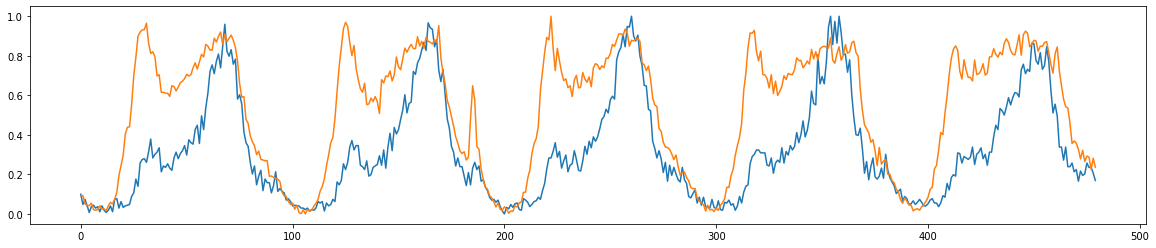

In [38]:
for i in range(Xs.shape[1]):
    plt.figure(figsize=[20,4])
    plt.plot(Xs[:, i])
    plt.plot(Xt[:, i])

## 1.d. Hyperparameters

In [39]:
label_seq_len = 3
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 12
layers = 1
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [40]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,1,1,3,12,4,12,1,3


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [41]:
Xs = Xs[:96, :]

In [42]:
# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, 1)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, 1)
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(84, 12, 1)
(84, 1, 1)
(468, 12, 1)
(468, 1, 1)


In [43]:
t_s = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):
    print('Starting det %i'%i)
    bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=0.6, gamma=1, T=5)  # T is iteration time
    Xs_new, Xt_new, A = bda.fit(
        Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
    )  # input shape: ns, n_feature | ns, n_label_feature
    
    # normalize
    Xs_new, Xs_new_min, Xs_new_max = bda_utils.normalize2D(Xs_new)
    Xt_new, Xt_new_min, Xt_new_max = bda_utils.normalize2D(Xt_new)
    
    print(Xs_new.shape)
    print(Xt_new.shape)

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(96*day_train_t):, :]
    Xt_train = Xt_new.copy()[:int(96*day_train_t), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(96*day_train_t):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(96*day_train_t), :]
    
    Xs_train_3d.append(Xs_train)
    Ys_train_3d.append(Ys_train)
    Xt_valid_3d.append(Xt_valid)
    Xt_train_3d.append(Xt_train)
    Yt_valid_3d.append(Yt_valid)
    Yt_train_3d.append(Yt_train)


Xs_train_3d = np.array(Xs_train_3d)
Ys_train_3d = np.array(Ys_train_3d)
Xt_valid_3d = np.array(Xt_valid_3d)
Xt_train_3d = np.array(Xt_train_3d)
Yt_valid_3d = np.array(Yt_valid_3d)
Yt_train_3d = np.array(Yt_train_3d)

# bda_utils.save_np(Xs_train_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Ys_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))

print('Time spent:%.5f'%(time.time()-t_s))

Starting det 0
	Starting iter 0
2951.8397435897436
	Starting iter 1
2459.8333333333335
	Starting iter 2
2485.948717948718
	Starting iter 3
2471.4102564102564
	Starting iter 4
2471.4102564102564
(84, 8)
(468, 8)
Time spent:1.91741


In [44]:
Xs_train_3d = np.transpose(Xs_train_3d, (1, 2, 0))
Ys_train_3d = np.transpose(Ys_train_3d, (1, 2, 0))
Xt_valid_3d = np.transpose(Xt_valid_3d, (1, 2, 0))
Xt_train_3d = np.transpose(Xt_train_3d, (1, 2, 0))
Yt_valid_3d = np.transpose(Yt_valid_3d, (1, 2, 0))
Yt_train_3d = np.transpose(Yt_train_3d, (1, 2, 0))

In [45]:
Xs_train_3d.shape

(84, 8, 1)

# 2. Learning Part

## 2.a. Build network

In [71]:
from bda_utils import traff_net_reg

ImportError: cannot import name 'traff_net_reg' from 'bda_utils' (C:\Users\10169\Documents\Github\BDA_traffic\bda_utils.py)

## 2.b. Assemble Dataloader

In [48]:
batch_size = 1960

train_x = np.vstack([Xs_train_3d, Xt_train_3d])
train_y = np.vstack([Ys_train_3d, Yt_train_3d])

train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
Xt_valid_3d = torch.tensor(Xt_valid_3d, dtype=torch.float32).to(device)
Yt_valid_3d = torch.tensor(Yt_valid_3d, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
train_iter = iter(train_loader)

print(train_x.shape)
print(train_y.shape)
print('\n')
print(Xt_valid_3d.shape)
print(Yt_valid_3d.shape)

torch.Size([180, 8, 1])
torch.Size([180, 1, 1])


torch.Size([372, 8, 1])
torch.Size([372, 1, 1])


## 2.c. Learn

In [49]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = traff_net_reg(1, label_dim, seq_len-reduced_dim).to(device)
criterion = nn.MSELoss()
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)
train_loss_set = []
val_loss_set = []

det = 0  # which detector to visualize

In [50]:
optimizer = torch.optim.Adam(net.parameters())

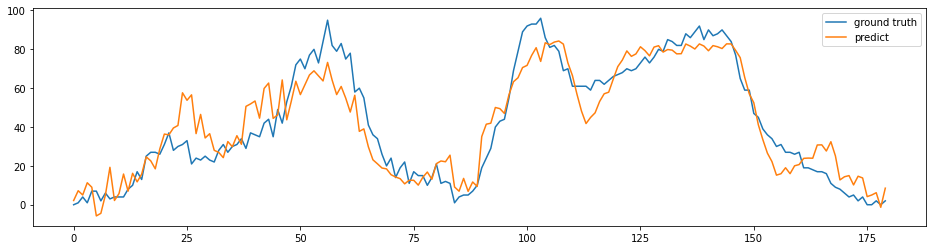

Epoch No. 0 success, loss: 122.25519, val loss: 132.16171


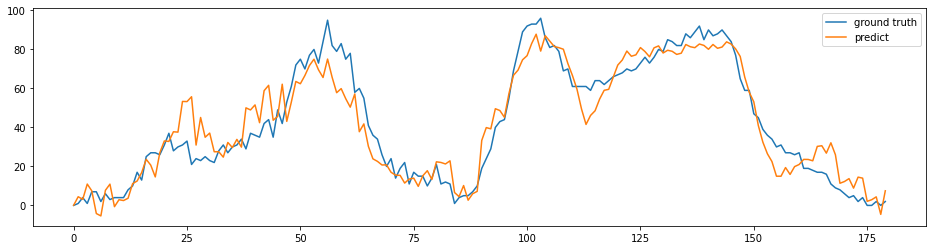

Epoch No. 50 success, loss: 100.31068, val loss: 125.26331


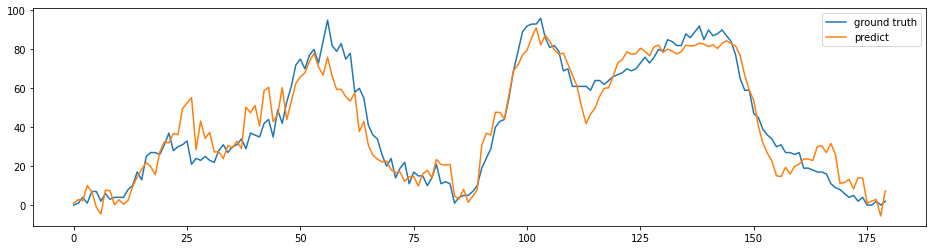

Epoch No. 100 success, loss: 87.79276, val loss: 122.55050


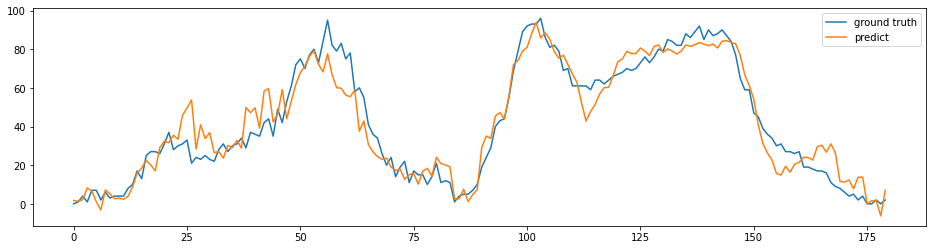

Epoch No. 150 success, loss: 77.96700, val loss: 122.00093


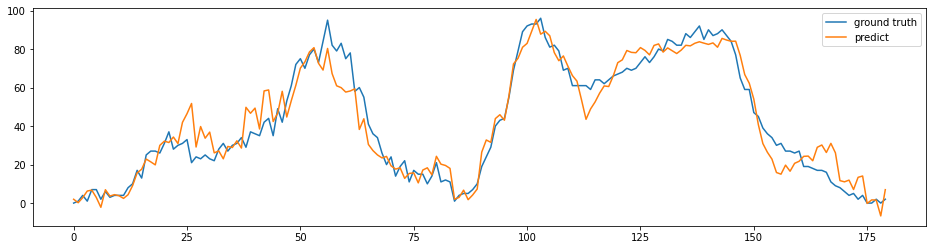

Epoch No. 200 success, loss: 69.65722, val loss: 121.93932


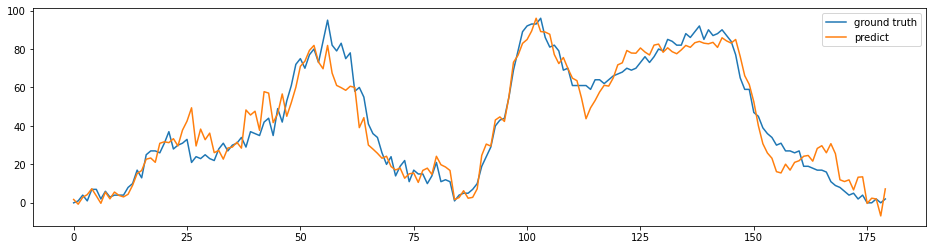

Epoch No. 250 success, loss: 62.39448, val loss: 124.38636


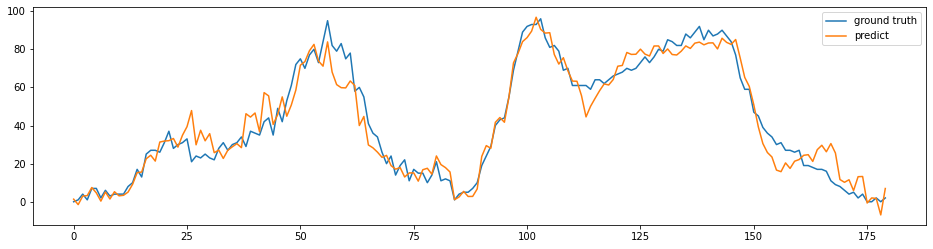

Epoch No. 300 success, loss: 56.52336, val loss: 126.71955


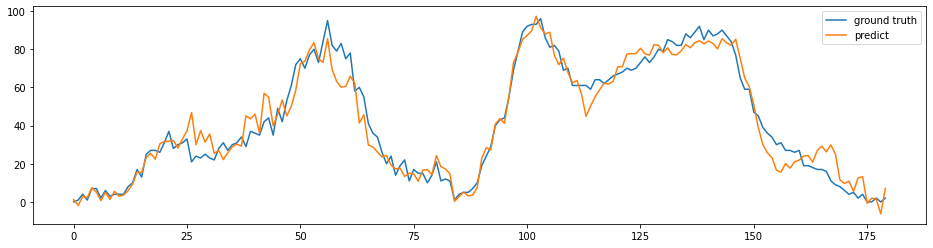

Epoch No. 350 success, loss: 51.81482, val loss: 129.01312


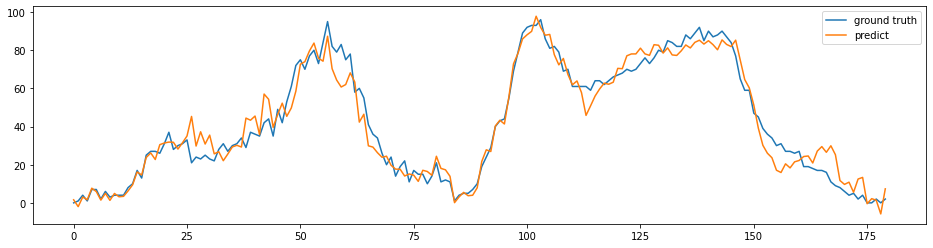

Epoch No. 400 success, loss: 47.97641, val loss: 132.52478


In [52]:
# train
net.train()

epochs = 401

for e in range(epochs):
    for i in range(len(train_loader)):
        try:
            data, label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, label = train_iter.next()
#         ipdb.set_trace()
        out = net(data)
        loss = criterion(out*100, bda_utils.get_class(label[:, 0, 0]).reshape(-1, 1) )  # label.shape=[batch, 1, num_dets]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        val_out = net(Xt_valid_3d)
        val_loss = criterion(val_out*100, bda_utils.get_class(Yt_valid_3d[:, 0, 0]).reshape(-1, 1) )
        
        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
        
    if e%50==0:
#         ipdb.set_trace()
        fig = plt.figure(figsize=[16,4])
        ax1 = fig.add_subplot(111)
        ax1.plot(bda_utils.get_class(label)[:, 0, det].cpu().detach().numpy(), label='ground truth')
        ax1.plot(100*out.cpu().detach().numpy(), label='predict')
        ax1.legend()
        plt.show()
        print('Epoch No. %i success, loss: %.5f, val loss: %.5f'\
              %(e, loss.cpu().detach().numpy(), val_loss.cpu().detach().numpy() ))

In [53]:
# bda_utils.save_np(Xs_new, 'Xs_new.csv')

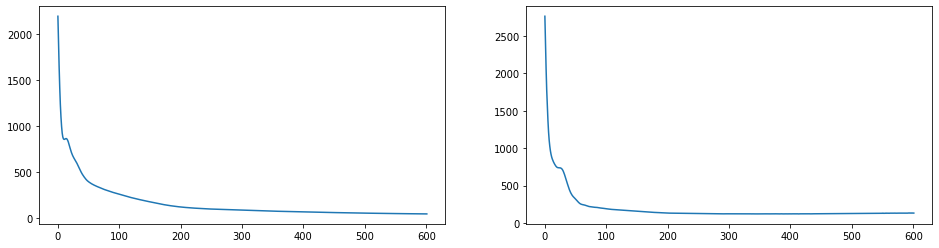

In [54]:
fig = plt.figure(figsize = [16, 4])
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_set)
ax2 = fig.add_subplot(122)
ax2.plot(val_loss_set)

# 3. Evaluation

In [ ]:
pred[pred<0]

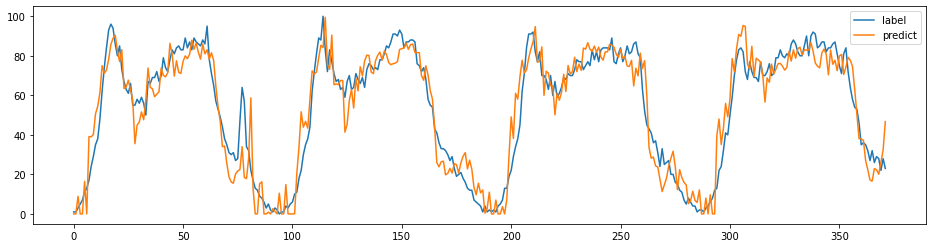

In [68]:
val_out = net(Xt_valid_3d)
g_t = bda_utils.get_class(Yt_valid_3d[:, 0, det]).cpu().flatten().detach().numpy()
pred = val_out.cpu().detach().numpy().flatten()*100
pred_ = pred.copy()
pred_[pred_<0] = 0

plt.figure(figsize=[16,4])
plt.plot(g_t, label='label')
plt.plot(pred_, label='predict')
plt.legend()

In [69]:
# sklearn.metrics.accuracy_score(torch.argmax(val_out, dim=1).cpu(), bda_utils.get_class(Yt_valid_3d[:, 0, det]).cpu().flatten())


print(bda_utils.nrmse_loss_func(g_t, pred, 0))
print(bda_utils.mape_loss_func(g_t, pred, 0))


0.07257898208332304
0.063861854


In [ ]:
# torch.save(net.state_dict(), './model/bda_weekday_M1_M4_nrmse=%.5f.pth'%nrmse_loss)